In [1]:
#This dataset contains information related to customer behavior in online shopping websites. 
#We use this data to predict whether the customer would make a purchase or not

In [2]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

In [3]:
#read in the dataset
data=pd.read_csv('/Users/shrutiparulekar/Desktop/data science/kaggle/shopper_intent/online_shoppers_intention.csv')
data.head()
data.index

RangeIndex(start=0, stop=12330, step=1)

In [4]:
##split the data into test and train
from sklearn.model_selection import train_test_split

X=data.iloc[:,:-1]
y=data['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [5]:
#perform exploratory data analysis on the training data

print(y_train.value_counts()/y_train.count())

#explore the features in the dataset
X_train.columns
X_train.describe()
X_train.isnull().any()
data = data.fillna(lambda x: x.median())
#there are some outliers in the data
#the minimum value for Administrative_Duration, Informational_Duration and ProductRelated_Duration is -1 
#also the maximum values for the some variables seem much larger than the 75th percentile

False    0.851002
True     0.148998
Name: Revenue, dtype: float64


In [6]:
##check the variable type and convert categorical variables to dummy variables

X_train.dtypes
X_train.loc[:, ['Weekend', 'VisitorType','Month']] = X_train.loc[:,['Weekend', 'VisitorType','Month']].astype('category')
train_dummy_vars = pd.get_dummies(X_train[['Weekend','VisitorType','Month']],drop_first=True)
X_train = pd.merge(X_train, train_dummy_vars, left_index=True, right_index=True)
X_train=X_train.drop(['Weekend', 'VisitorType','Month'],axis=1)
X_test.loc[:, ['Weekend', 'VisitorType','Month']] = X_test.loc[:,['Weekend', 'VisitorType','Month']].astype('category')
test_dummy_vars = pd.get_dummies(X_test[['Weekend','VisitorType','Month']],drop_first=True)
X_test = pd.merge(X_test, test_dummy_vars, left_index=True, right_index=True)
X_test=X_test.drop(['Weekend', 'VisitorType','Month'],axis=1)

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Text(0.5, 1.0, 'Plot Displaying the Coorelation Between Features')

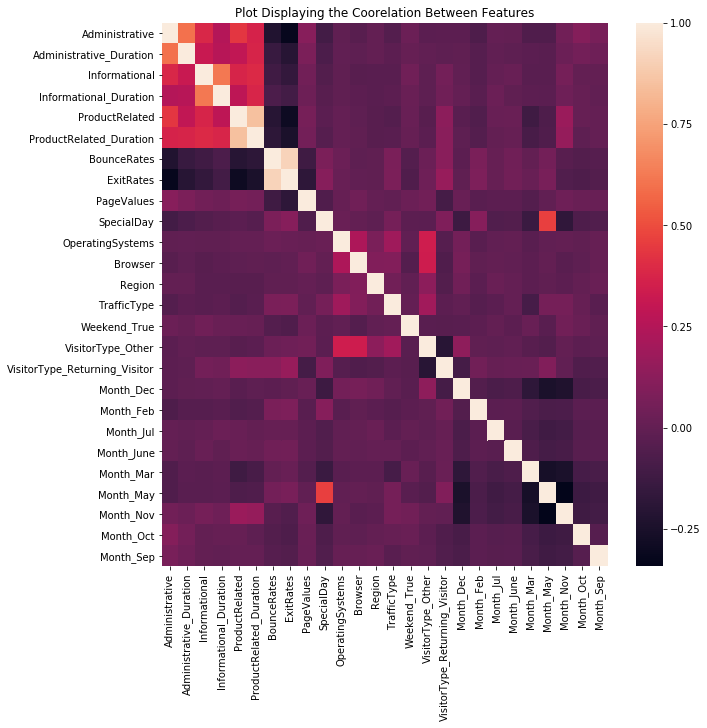

In [7]:
##checking the coorelation between variables 
corr = X_train.corr()

# plot the heatmap
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns)
plt.title('Plot Displaying the Coorelation Between Features')
##there seems to be a greater coorelation between Adminstrative/Informational/ProductRelated variables and their respective durations

In [8]:
##fitting a xgboost prediction model
# CV model
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


#fit model and train
model = XGBClassifier(learning_rate = 0.05, n_estimators=100, max_depth=5)
model.fit(X_train, y_train)

# using k fold cross validation to get the precision recall auc
xgb_pr_auc=cross_val_score(model, X_train, y_train, cv=5, scoring = 'average_precision')
avg_xgb_pr_auc=xgb_pr_auc.mean()
print("Precision Recall AUC using XGBoost Classifier is" , avg_xgb_pr_auc)

Precision Recall AUC using XGBoost Classifier is 0.7528646310892044


In [9]:
##check if the auc changes by changing parameters
##looping through n_estimators

n_estimators_list=[10,100,300]
for n in n_estimators_list:
    model = XGBClassifier(learning_rate = 0.05, n_estimators=n, max_depth=5)
    model.fit(X_train, y_train)

    # using k fold cross validation to get the precision recall auc
    xgb_pr_auc=cross_val_score(model, X_train, y_train, cv=5, scoring = 'average_precision')
    avg_xgb_pr_auc=xgb_pr_auc.mean()
    print("Precision Recall AUC using XGBoost Classifier for n_estimators=",n, "is" , avg_xgb_pr_auc)

##note there is not substantial gain in the AUC after increasing the n_estimators to 300 compared to 100
##given the increased computing time needed to run the model with 300 estimators 
##using 100 estimators might be reasonable

Precision Recall AUC using XGBoost Classifier for n_estimators= 10 is 0.7231890558805831
Precision Recall AUC using XGBoost Classifier for n_estimators= 100 is 0.7528646310892044
Precision Recall AUC using XGBoost Classifier for n_estimators= 300 is 0.7400727707429835


In [10]:
##fit the test set data to get predictions
model = XGBClassifier(learning_rate = 0.05, n_estimators=100, max_depth=5)
model.fit(X_train, y_train)

#get predictions for the test data
y_test_probs=model.predict(X_test)

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

precision, recall, thresholds = precision_recall_curve(y_test, y_test_probs)
avg_xgb_pr_auc_test=auc(recall, precision)
print("Precision Recall AUC using XGBoost Classifier for the test data is" , avg_xgb_pr_auc_test)

Precision Recall AUC using XGBoost Classifier for the test data is 0.7011954243999918


Text(0, 0.5, 'Features')

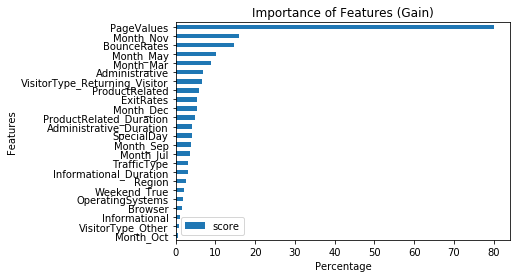

In [11]:
##summarize/plot the important features 
feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh')
plt.title("Importance of Features (Gain)")
plt.xlabel("Percentage")
plt.ylabel("Features")